# basisegressie analyse Student Performance dataset

In dit notebook doen we een regressie analyse op de student performance dataset. De Student Performance dataset bevat data over de performance van studenten bij twee verschillende Portugese scholen.

![](https://odinland.vn/wp-content/uploads/2020/06/29.06-portugal.jpg)

De dataset kun je vinden op Teams.


Het doel van de regressie analyse is om de onafhankelijke variabele (G3) te kunnen voorspellen met de afhankelijke variabelen. Dit document is een vervolg van de gevordedeverkennende analyse. hieruit heb ik de volgende conclusies uitgetrokken:

- Je ziet dat de meeste studenten rond het cijfer 10 halen en dat er gaanderweg de studie, meer studenten het cijfer 0 krijgen.
- Veel categorische variabelen hebben één waarde die sterk overheerst.
- De numerieke variabelen zijn beide rechtsscheef
- De afhankelijke variabelen hebben een hoge correlatie
- De numerieke variabelen hebben een lage correlatie
- variabelen zoals higher hebben een hoge variantie
- Age, G1, G2 Medu, Fedu en famrel hebben een hoge multicollinearity

We beginnen zoals gebruikelijk met de import statements.

In [122]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import itertools
from itertools import combinations


import scipy.stats as stats
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression

from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import ElasticNet


from scipy.stats import spearmanr

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import r2_score
from scipy.stats import chi2_contingency


from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
import category_encoders as ce
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

from sklearn.discriminant_analysis import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import FunctionTransformer

import h2o
from h2o.automl import H2OAutoML

from statsmodels.stats.outliers_influence import variance_inflation_factor


## Task1: Load the data and separate columns

In [77]:
df = pd.read_csv("data/student_performance_gevorderd.csv")
df

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3,course
0,GP,F,18.0,U,GT3,A,4.0,4.0,at_home,teacher,...,3,4,1,1,3,6,5,6,6,mat
1,GP,F,17.0,U,GT3,T,1.0,1.0,at_home,other,...,3,3,1,1,3,4,5,5,6,mat
2,GP,F,15.0,U,LE3,T,1.0,1.0,at_home,other,...,3,2,2,3,3,10,7,8,10,mat
3,GP,F,15.0,U,GT3,T,4.0,2.0,health,services,...,2,2,1,1,5,2,15,14,15,mat
4,GP,F,16.0,U,GT3,T,3.0,3.0,other,other,...,3,2,1,2,5,4,6,10,10,mat
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1039,MS,F,19.0,R,GT3,T,2.0,3.0,services,other,...,4,2,1,2,5,4,10,11,10,por
1040,MS,F,18.0,U,LE3,T,3.0,1.0,teacher,services,...,3,4,1,1,1,4,15,15,16,por
1041,MS,F,18.0,U,GT3,T,1.0,1.0,other,other,...,1,1,1,1,5,6,11,12,9,por
1042,MS,M,17.0,U,LE3,T,NaN,NaN,services,services,...,4,5,3,4,2,6,10,10,10,por


De data is nu ingeladen laten we nu kijken naar de outliers

In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1044 entries, 0 to 1043
Data columns (total 34 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   school      1044 non-null   object 
 1   sex         1044 non-null   object 
 2   age         1023 non-null   float64
 3   address     1044 non-null   object 
 4   famsize     1044 non-null   object 
 5   Pstatus     1044 non-null   object 
 6   Medu        1016 non-null   float64
 7   Fedu        1016 non-null   float64
 8   Mjob        1044 non-null   object 
 9   Fjob        1044 non-null   object 
 10  reason      1044 non-null   object 
 11  guardian    971 non-null    object 
 12  traveltime  1044 non-null   int64  
 13  studytime   1044 non-null   int64  
 14  failures    1044 non-null   int64  
 15  schoolsup   1044 non-null   object 
 16  famsup      1044 non-null   object 
 17  paid        1044 non-null   object 
 18  activities  1044 non-null   object 
 19  nursery     1044 non-null  

Wat opvalt is dat het veel variabelen zijn, 80. Daarom is het wat lastig om een data dictionary te maken. Bovendien zijn alle variabelen al beschreven in het bestand data_description.txt.

Van die 34 variabelen is er de afhankelijke variabele SalePrice en de rest zijn onafhankelijke variabelen.

We doorlopen de data description om de variabelen in te delen in de volgende soorten:
- afhankelijke variabelen 
- onafhankelijke categorische variabelen
- onafhankelijke numerieke variabelen


Deze indeling helpt om het verkennen van de afzonderlijke variabelen systematisch op te zetten.

In [79]:
af_vars = ['G3']
on_cat_vars = ['school', 'sex', 'address', 'famsize', 'Pstatus',  'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason',
               'guardian','failures','traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 
               'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc',
              'Walc', 'health', 'course']
on_num_vars = ['age', 'absences','G1', 'G2',]
all_vars = af_vars + on_cat_vars + on_num_vars
print(len(af_vars) + len(on_cat_vars) + len(on_num_vars) )
print(all_vars)
print(len(all_vars))

35
['G3', 'school', 'sex', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'failures', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'course', 'age', 'absences', 'G1', 'G2']
35


In [80]:
print(on_cat_vars)

['school', 'sex', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'failures', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'course']


Hier worden de categorische en numerieke variabelen opgesplitst. Hieronder gaan we kijken od=f de categorische variabelen moeten worden encoded.

## Task 2: Data Preprocessing

#### Encoding

In [81]:
lijst = []

for i in on_cat_vars:
    lijst.append(df[i].unique())
lijst

[array(['GP', 'MS'], dtype=object),
 array(['F', 'M'], dtype=object),
 array(['U', 'R'], dtype=object),
 array(['GT3', 'LE3'], dtype=object),
 array(['A', 'T'], dtype=object),
 array([ 4.,  1.,  3.,  2., nan,  0.]),
 array([ 4.,  1.,  2.,  3., nan,  0.]),
 array(['at_home', 'health', 'other', 'services', 'teacher'], dtype=object),
 array(['teacher', 'other', 'services', 'health', 'at_home'], dtype=object),
 array(['course', 'other', 'home', 'reputation'], dtype=object),
 array(['mother', 'father', nan], dtype=object),
 array([0, 3, 2, 1], dtype=int64),
 array([2, 1, 3, 4], dtype=int64),
 array([2, 3, 1, 4], dtype=int64),
 array([0, 3, 2, 1], dtype=int64),
 array(['yes', 'no'], dtype=object),
 array(['no', 'yes'], dtype=object),
 array(['no', 'yes'], dtype=object),
 array(['no', 'yes'], dtype=object),
 array(['yes', 'no'], dtype=object),
 array(['yes', 'no'], dtype=object),
 array(['no', 'yes'], dtype=object),
 array(['no', 'yes'], dtype=object),
 array([4, 5, 3, 1, 2], dtype=int64),
 a

Hier zie je dat sommige categorische variabelen encoded moet worden zodat het machine learning algortime mee kan werken.



In [82]:
label_encoders = {}

# Iterate through columns and apply LabelEncoder
for col, values in zip(on_cat_vars, lijst):
    le = LabelEncoder()
    le.fit(values)
    label_encoders[col] = le
    # Transform the original data with the fitted encoder
    # Assuming your data is in a DataFrame called 'df'
    df[col] = df[col].apply(lambda x: le.transform([x])[0] if pd.notna(x) else x)


In [83]:
lijst = []

for i in on_cat_vars:
    lijst.append(df[i].unique())
    lijst.append(i)


lijst

[array([0, 1]),
 'school',
 array([0, 1]),
 'sex',
 array([1, 0]),
 'address',
 array([0, 1]),
 'famsize',
 array([0, 1]),
 'Pstatus',
 array([ 4.,  1.,  3.,  2., nan,  0.]),
 'Medu',
 array([ 4.,  1.,  2.,  3., nan,  0.]),
 'Fedu',
 array([0, 1, 2, 3, 4]),
 'Mjob',
 array([4, 2, 3, 1, 0]),
 'Fjob',
 array([0, 2, 1, 3]),
 'reason',
 array([ 1.,  0., nan]),
 'guardian',
 array([0, 3, 2, 1], dtype=int64),
 'failures',
 array([1, 0, 2, 3], dtype=int64),
 'traveltime',
 array([1, 2, 0, 3], dtype=int64),
 'studytime',
 array([0, 3, 2, 1], dtype=int64),
 'failures',
 array([1, 0]),
 'schoolsup',
 array([0, 1]),
 'famsup',
 array([0, 1]),
 'paid',
 array([0, 1]),
 'activities',
 array([1, 0]),
 'nursery',
 array([1, 0]),
 'higher',
 array([0, 1]),
 'internet',
 array([0, 1]),
 'romantic',
 array([3, 4, 2, 0, 1], dtype=int64),
 'famrel',
 array([2, 1, 3, 0, 4], dtype=int64),
 'freetime',
 array([3, 2, 1, 0, 4], dtype=int64),
 'goout',
 array([0, 1, 4, 2, 3], dtype=int64),
 'Dalc',
 array([0, 2

Ja! alles is nu geencode.

#### Missing Values
In de verkennende analyese is er al gekeken naar de missing values. Laten we die gegevens weer even ophalen.

In [84]:
df.isnull().sum()

school         0
sex            0
age           21
address        0
famsize        0
Pstatus        0
Medu          28
Fedu          28
Mjob           0
Fjob           0
reason         0
guardian      73
traveltime     0
studytime      0
failures       0
schoolsup      0
famsup         0
paid           0
activities     0
nursery        0
higher         0
internet       0
romantic       0
famrel         0
freetime       0
goout          0
Dalc           0
Walc           0
health         0
absences       0
G1             0
G2             0
G3             0
course         0
dtype: int64

Hier zie je veel values die missen. Die moeten opgevuld worden. Eerst ga ik de missing numerieke en categorische opsplitsen.

In [85]:
missing_cat = ['Medu', 'Fedu', 'guardian']
missing_num = ['age']

### Missing values vullen

We hebben bij het analyseren van de individuele variabelen hierboven al aardig wat uitspraken gedaan over missing values. Hieronder formuleer ik een strategie voor het vullen van de missing values.
voor numerieke waarden wil ik het gemiddelde gebruiken en voor categorische waarden wil ik de mediaan gebruiken.
### Numeriek

In [86]:
df['age'].fillna(df['age'].median(), inplace=True)


De numerieke waardes kan je via de mediaan van de kolom opvullen. Dat doe ik hierboven ook.

### Categorisch

In [87]:
for col in missing_cat:
    df[col].fillna(df[col].mode()[0], inplace=True) 

Bij de categorische waardes kan je de modus van het kolom gebruiken

In [88]:
df.isnull().sum()

school        0
sex           0
age           0
address       0
famsize       0
Pstatus       0
Medu          0
Fedu          0
Mjob          0
Fjob          0
reason        0
guardian      0
traveltime    0
studytime     0
failures      0
schoolsup     0
famsup        0
paid          0
activities    0
nursery       0
higher        0
internet      0
romantic      0
famrel        0
freetime      0
goout         0
Dalc          0
Walc          0
health        0
absences      0
G1            0
G2            0
G3            0
course        0
dtype: int64

Ja! de missing values zijn er uit gehaald!.

### Binaire variables
We gaan nu kijken naar de binaire categorische variabelen

In [89]:
binary_columns = []
for column in df.columns:
    unique_values = df[column].unique()
    if np.isin(unique_values, [0, 1]).all():
        binary_columns.append(column)
print(binary_columns)

['school', 'sex', 'address', 'famsize', 'Pstatus', 'guardian', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'course']


Dit zijn alle binaire kolommen, laten we die onderzoeken met een histogram

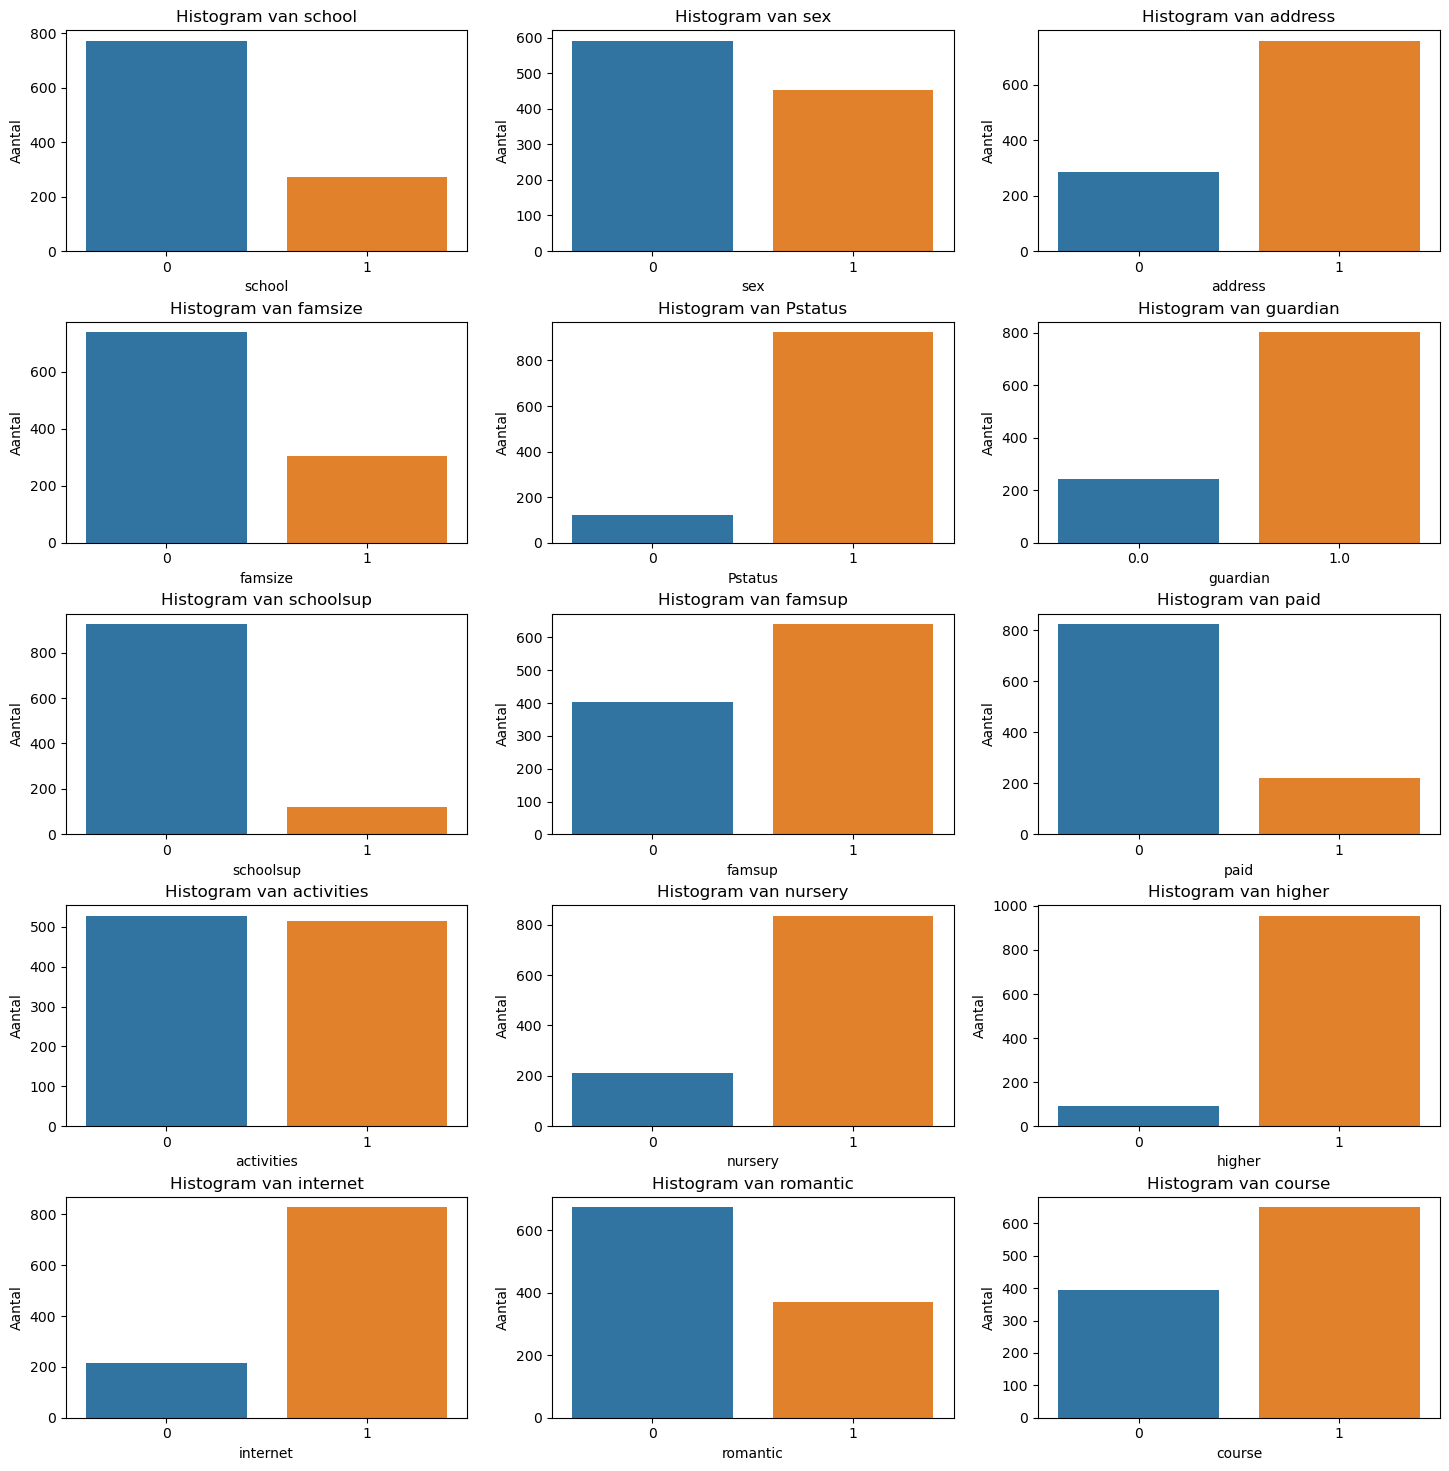

In [90]:
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(15, 15))
fig.tight_layout(pad=3.0)

for i, column in enumerate(df[binary_columns]):
    ax = axes[i // 3, i % 3]
    sns.countplot(data=df, x=column, ax=ax)
    ax.set_title(f'Histogram van {column}')
    ax.set_xlabel(column)
    ax.set_ylabel('Aantal')

plt.show()

De volgende variabelen zijn oneerlijk verdeeld:
- Pstatus
- schoolsup
- paid
- nursery
- higher
- internet
- guardian
- failures

Deze kunnen verwijderd worden

In [91]:
df.drop('Pstatus', inplace=True, axis=1)
all_vars.remove('Pstatus')
on_cat_vars.remove('Pstatus')

df.drop('schoolsup', inplace=True, axis=1)
all_vars.remove('schoolsup')
on_cat_vars.remove('schoolsup')

df.drop('paid', inplace=True, axis=1)
all_vars.remove('paid')
on_cat_vars.remove('paid')

df.drop('nursery', inplace=True, axis=1)
all_vars.remove('nursery')
on_cat_vars.remove('nursery')

df.drop('higher', inplace=True, axis=1)
all_vars.remove('higher')
on_cat_vars.remove('higher')

df.drop('internet', inplace=True, axis=1)
all_vars.remove('internet')
on_cat_vars.remove('internet')

df.drop('guardian', inplace=True, axis=1)
all_vars.remove('guardian')
on_cat_vars.remove('guardian')

df.drop('failures', inplace=True, axis=1)
all_vars.remove('failures')
on_cat_vars.remove('failures')

In [92]:
def check_outliers():
    fig, axes = plt.subplots(nrows=len(all_vars) // 3 + 1, ncols=3, figsize=(15, 5 * (len(all_vars) // 3 + 1)))
    axes = axes.flatten()

    for variable, ax in zip(all_vars, axes):
        sns.boxplot(x=variable, data=df, ax=ax)
        ax.set_title(f'Boxplot of {variable}')
    plt.tight_layout()
    plt.show()

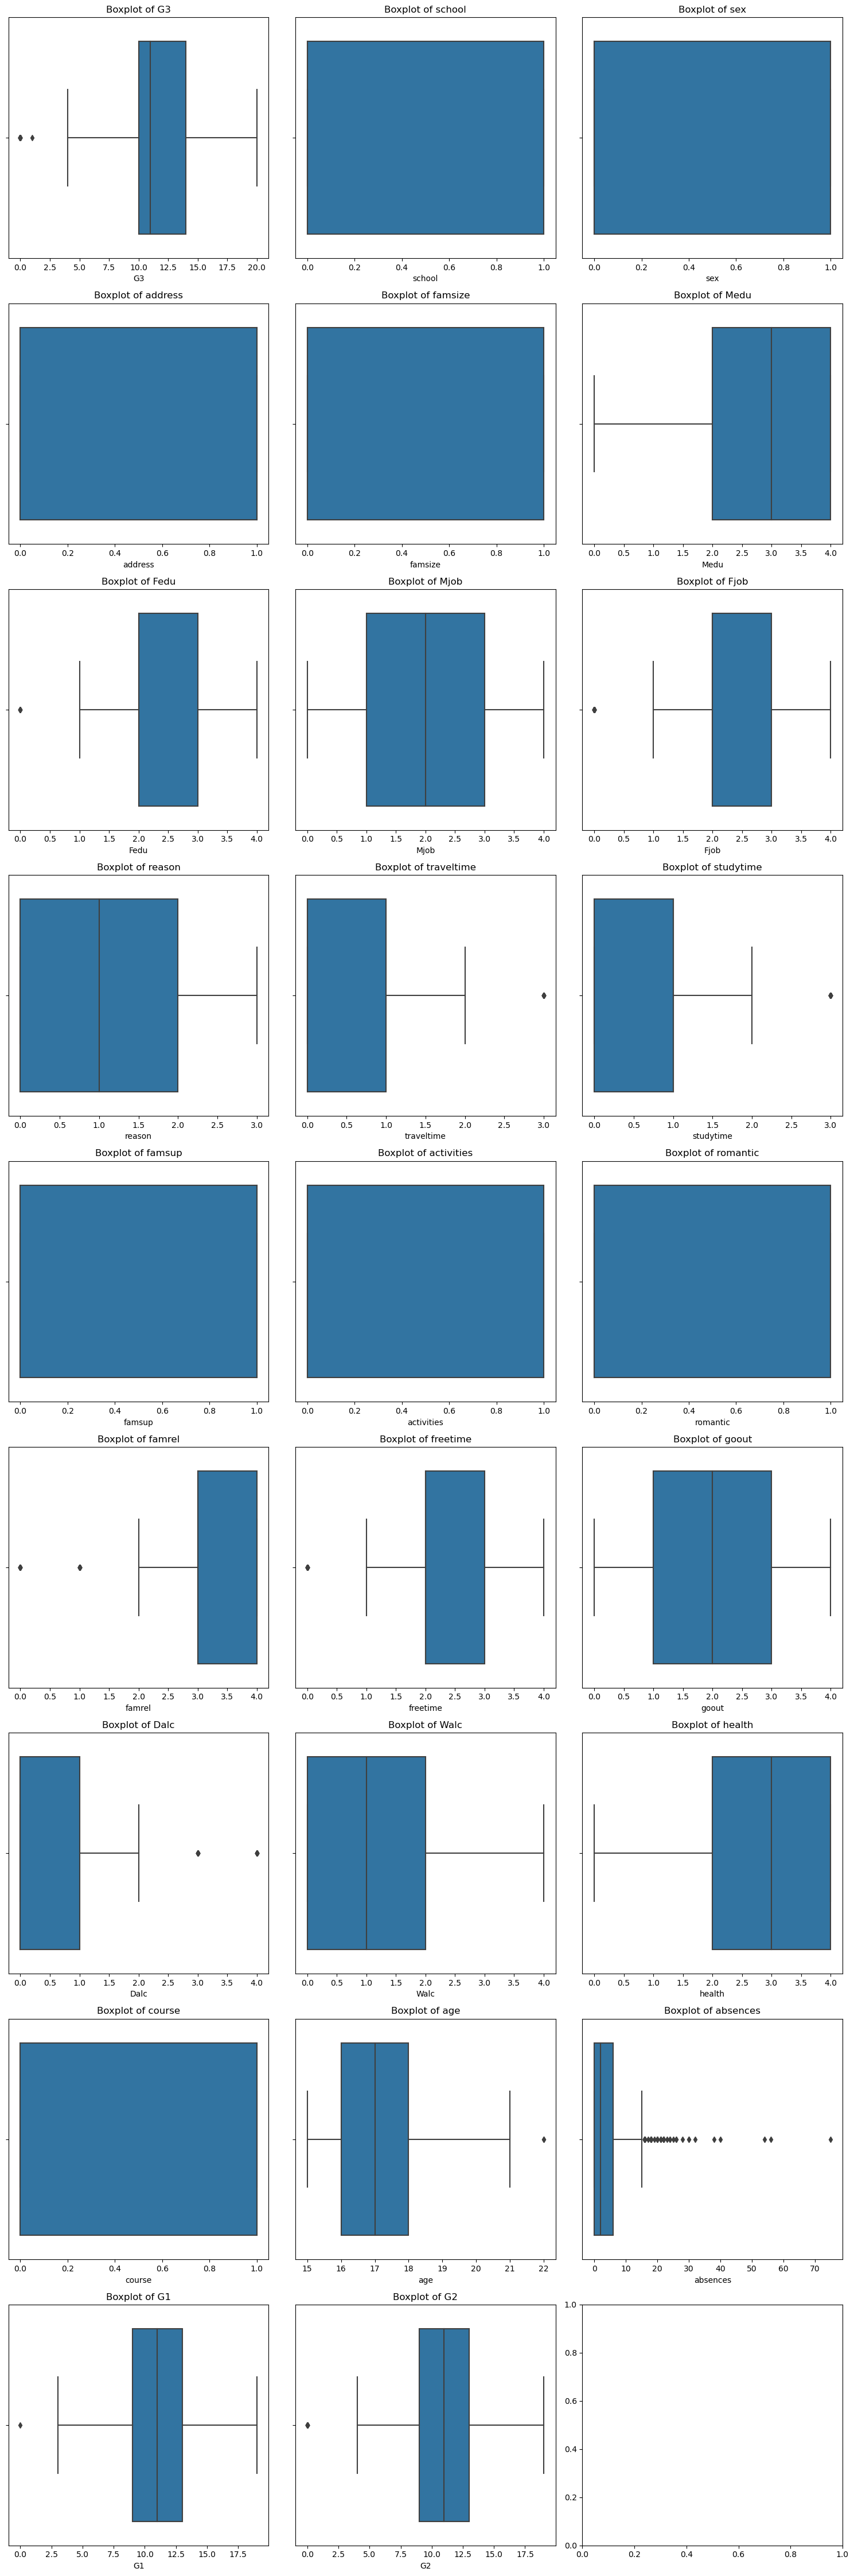

In [93]:
all_vars.remove('failures')
on_cat_vars.remove('failures')

check_outliers()

Laten we nu de outliers verwijderen

In [94]:
def verwijder_outliers(series):
    # Removing outliers based on IQR
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1

    # Using the IQR filter to remove outliers
    return series.loc[(series >= Q1 - 1.5 * IQR) & (series <= Q3 + 1.5 * IQR)]

In [95]:
for i in all_vars:
    df[i] = verwijder_outliers(df[i])

In [96]:
df = df.dropna()

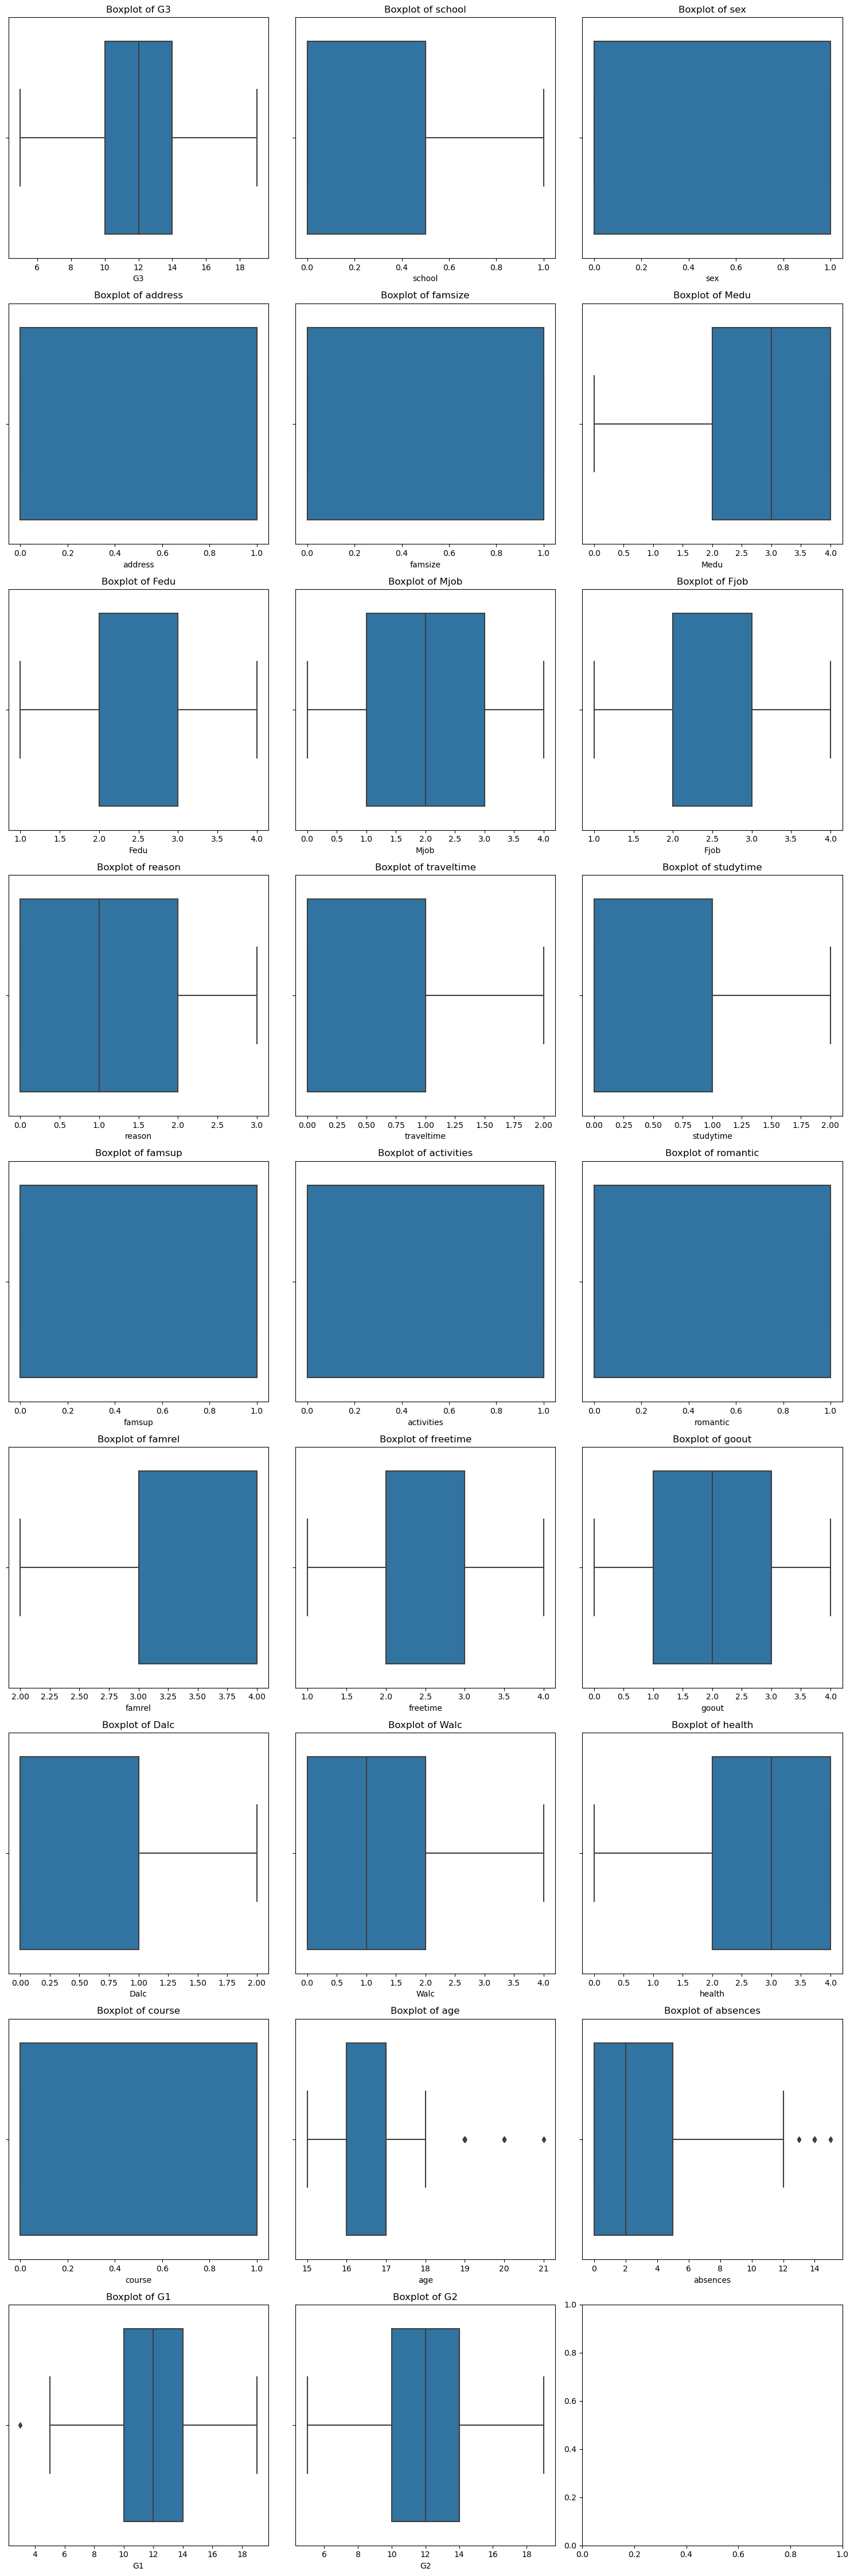

In [97]:
check_outliers()

In [98]:
#  bij categorsischer variabelen een histogram maken

Mooi! De outliers zijn zo goed als verdwenen

## Task 3: Regression Analysis
Eerst moeten we de correlaties eruit halen. In de gevordede verkennende analyse hebben we ondervonden dat G1, G2 en G3 correleren met elkaar, Medu en Fedu, en tot slot Dalc en Walc. ik verwijder G1, Fedu en Walc verwijderen. Waarom haal ik G2 er niet uit? Dit komt later nog aan bod.

In [99]:
df_copy = df.copy()


df_copy.drop('Fedu', inplace=True, axis=1)
on_cat_vars.remove('Fedu')
all_vars.remove('Fedu')

df_copy.drop('G1', inplace=True, axis=1)
on_num_vars.remove('G1')
all_vars.remove('G1')

df_copy.drop('Walc', inplace=True, axis=1)
on_cat_vars.remove('Walc')
all_vars.remove('Walc')

df = df_copy

In [100]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 671 entries, 0 to 1043
Data columns (total 23 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   school      671 non-null    int32  
 1   sex         671 non-null    int32  
 2   age         671 non-null    float64
 3   address     671 non-null    int32  
 4   famsize     671 non-null    int32  
 5   Medu        671 non-null    float64
 6   Mjob        671 non-null    int32  
 7   Fjob        671 non-null    float64
 8   reason      671 non-null    int32  
 9   traveltime  671 non-null    float64
 10  studytime   671 non-null    float64
 11  famsup      671 non-null    int32  
 12  activities  671 non-null    int32  
 13  romantic    671 non-null    int32  
 14  famrel      671 non-null    float64
 15  freetime    671 non-null    float64
 16  goout       671 non-null    int64  
 17  Dalc        671 non-null    float64
 18  health      671 non-null    int64  
 19  absences    671 non-null    float

Ja! de onnodige waardes zijn weg. Laten we nu kijken of de correlaties weg zijn.

<Axes: >

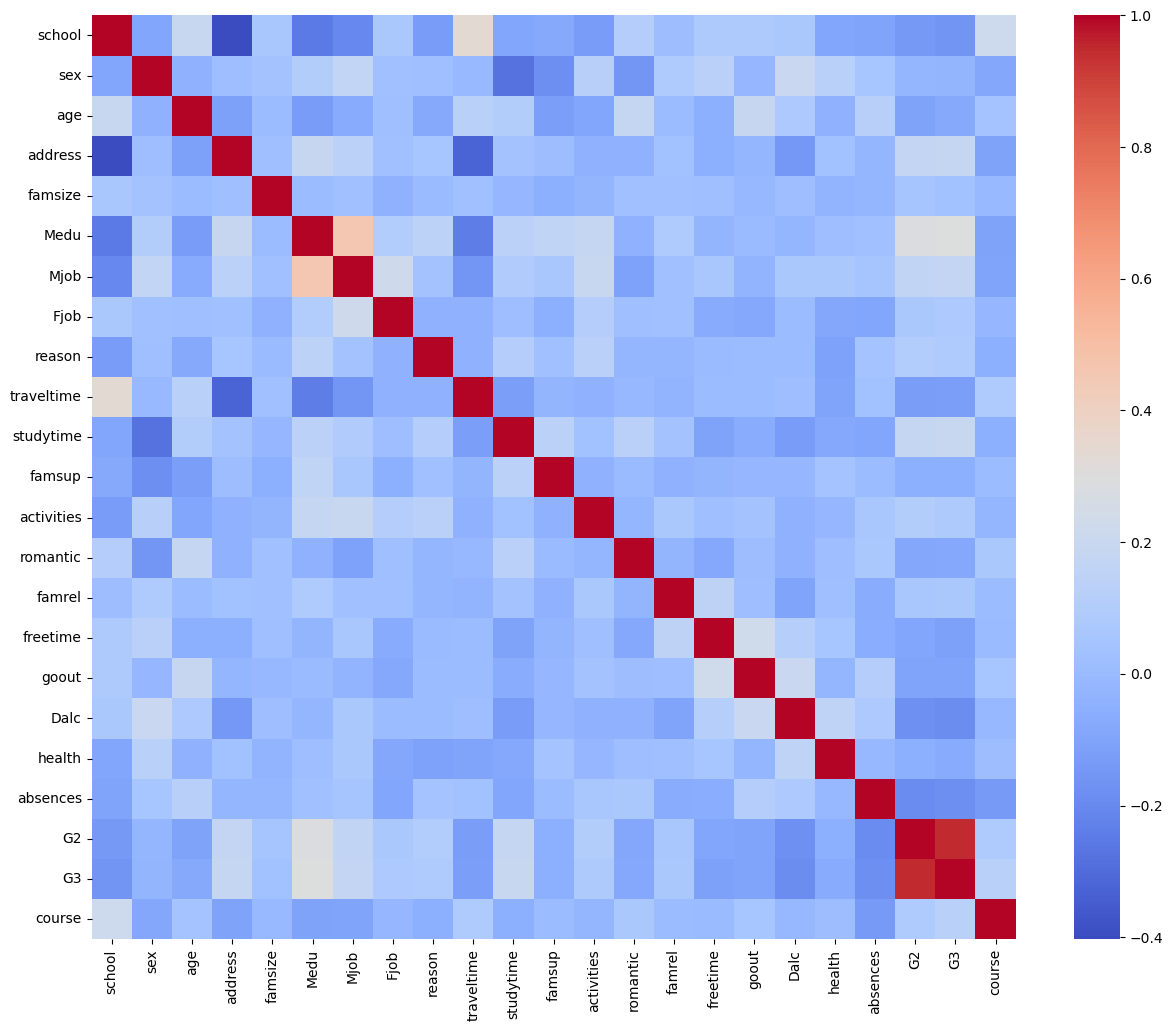

In [101]:
corr = df.corr(method="spearman")
plt.subplots(figsize=(15, 12))
sns.heatmap(corr, annot=False, cmap='coolwarm', square=True)

Inderdaad, de correlaties zijn weg. Laten we dit ook nog controleren dorrmiddel van een tabel.

In [102]:
threshold = 0.5
var1s = []
var2s = []
ccs = []
for permutation in list(itertools.combinations(all_vars, 2)):
    var1, var2 = permutation[0], permutation[1]
    cc = df[var1].corr(df[var2], method="spearman")
    if (cc > threshold or cc < -threshold) and cc != 1:
        var1s.append(var1)
        var2s.append(var2)
        ccs.append(cc)

corrs_df = pd.DataFrame({"Variabele 1": var1s, "Variabele 2": var2s, "Correlatie coëfficiënt": ccs})
corrs_df.sort_values("Correlatie coëfficiënt", ascending=False)

,Variabele 1,Variabele 2,Correlatie coëfficiënt
0,G3,G2,0.950649


Dit klopt helemaal naar verwachting


### Onafhankelijke en afhankelijke variabelen

In [103]:
onafhankelijke_vars = on_cat_vars + on_num_vars

y = df['G3']
x = df.drop(['G3'], axis=1)

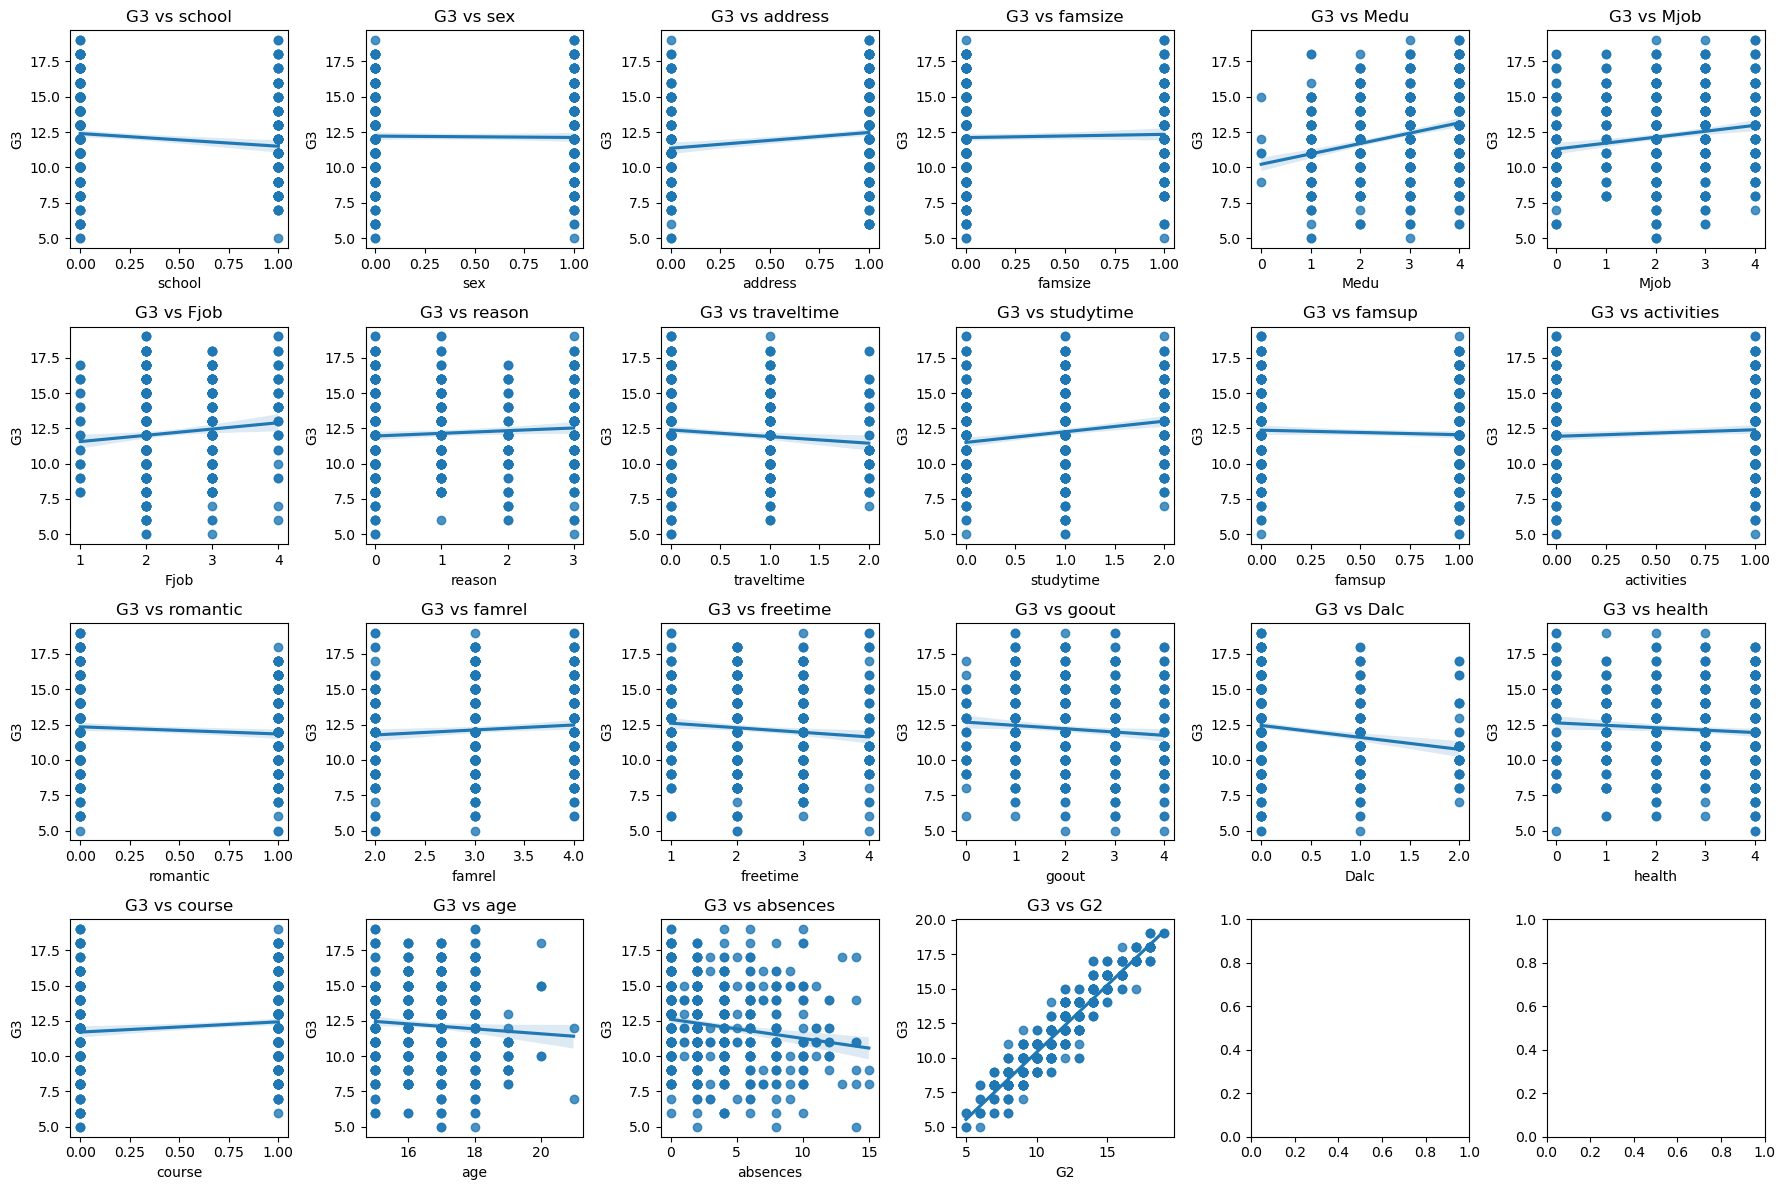

In [104]:
fig, axs = plt.subplots(4, 6, figsize=(18, 12))
axs = axs.flatten()

# Loop to plot each variable vs SalePrice
for idx, var in enumerate(onafhankelijke_vars):
    sns.regplot(x=x[var], y=y, ax=axs[idx])
    axs[idx].set_title('G3 vs '+var)

plt.tight_layout()
plt.show()


Hier zie je vrijwel direct dat G2 en G3 een mooie regressielijn hebben. Dat klinkt ook logisch omdat zij een goede correlatie hebben. Verder hebben G3 en Medu ook een prima regressielijn. ook zien we dat het eindcijfer drastisch omlaag gaat, als de studenten door de weeks alcohol drinken en als laatst: hoe ouder je bent, hoe slechter je eindcijfer is. dit geldt ook voor absences: hoe meer absenties, hoe lager cijfer je hebt.

Laten we deze waarden allemaal bekijken via het Spearman coefficient:

In [105]:
speareman_corr = []
for i in onafhankelijke_vars:
    corr, _ = spearmanr(x[i], y)
    speareman_corr.append(f"{i}: {corr}")
speareman_corr

['school: -0.1608587646533233',
 'sex: -0.030252786456369127',
 'address: 0.18323065536084732',
 'famsize: 0.031154932157386524',
 'Medu: 0.29572650172658005',
 'Mjob: 0.17592875103683991',
 'Fjob: 0.07465519571121984',
 'reason: 0.08555053149418622',
 'traveltime: -0.12029983757604507',
 'studytime: 0.1887900973704029',
 'famsup: -0.049657063546745435',
 'activities: 0.08381556730220446',
 'romantic: -0.0807158828277084',
 'famrel: 0.071979562089001',
 'freetime: -0.11668377360190937',
 'goout: -0.1007433716448932',
 'Dalc: -0.1881967284947513',
 'health: -0.07013828998081215',
 'course: 0.12358787643656217',
 'age: -0.07680741334889965',
 'absences: -0.1821134931173656',
 'G2: 0.9506491187221313']

Hieruit kunnen we hetzelfde concluderen als de visualisatie.

### Regressie
Het eerste wat we doen is de data splitsen in train en test data

In [106]:
X_train_simple, X_test_simple, y_train_simple, y_test_simple = train_test_split(x, y, test_size=0.2, random_state=42)

#### multicollinearity
Laten we eerst kijken naar de multicollinearity. Multicollineariteit is een statistisch fenomeen waarin twee of meer onafhankelijke variabelen in een regressiemodel sterk gecorreleerd zijn. in de gevordede verkennende analyse hebben hier al naar gekeken. laten we de data die hoog uit de VIF score komen, verwijderen.

In [107]:
df_copy = df.copy()


df_copy.drop('age', inplace=True, axis=1)
on_num_vars.remove('age')
all_vars.remove('age')

df_copy.drop('famrel', inplace=True, axis=1)
on_cat_vars.remove('famrel')
all_vars.remove('famrel')

df_copy.drop('Fjob', inplace=True, axis=1)
on_cat_vars.remove('Fjob')
all_vars.remove('Fjob')

df_copy.drop('Mjob', inplace=True, axis=1)
on_cat_vars.remove('Mjob')
all_vars.remove('Mjob')

df_copy.drop('freetime', inplace=True, axis=1)
on_cat_vars.remove('freetime')
all_vars.remove('freetime')

df = df_copy


In [108]:

y = df['G3']
x = df.drop(['G3'], axis=1)
X_train_simple, X_test_simple, y_train_simple, y_test_simple = train_test_split(x, y, test_size=0.2, random_state=42)

In [109]:
vif_data = pd.DataFrame()
vif_data["Variable"] = X_train_simple.columns
# Calculate VIF for each variable
vif_data["VIF"] = [variance_inflation_factor(X_train_simple.values, i) for i in range(X_train_simple.shape[1])]
vif_data_sorted = vif_data.sort_values(by='VIF', ascending=False)
print(vif_data_sorted)


      Variable        VIF
15          G2  16.310833
4         Medu   8.452431
2      address   4.695559
11       goout   4.671730
13      health   4.433636
7    studytime   3.334937
16      course   3.158453
8       famsup   2.818806
9   activities   2.296109
1          sex   2.173558
5       reason   2.009984
14    absences   1.936422
0       school   1.754866
6   traveltime   1.695325
10    romantic   1.650325
12        Dalc   1.492514
3      famsize   1.439416


G2 is hoog zou je denken. Juist, maar G2 is heel belangrijk voor het model. Dat kan je hieronder goed zien.

In [110]:
regression_model = LinearRegression()
regression_model.fit(X_train_simple[['G2']], y_train_simple)
y_predict = regression_model.predict(X_test_simple[['G2']])
r_squared = r2_score(y_test_simple, y_predict)
print(r_squared)

0.9062595144889528


Kijk! G1 bepaald al bija voor 91%, de onafhankelijke waarde. Laten we bu kiijken of we dit hoger kunnen krijgen.

### Forward Selection
Nu gaan we via forward selection kijken naar het model om er achter te komen wat de hoogste accuracy is.


In [119]:
model = LinearRegression()
selector = RFECV(estimator=model, step=1, cv=5)
selector.fit(X_train_simple, y_train_simple)

selected_features = X_train_simple.columns[selector.support_]


highest = 0
best_variable = ""
regression_model = LinearRegression()
# Iterate through all possible combinations
for r in range(1, len(selected_features) + 1):
    for variable_combination in combinations(selected_features, r):
        # Fit a linear regression model
        X = X_train_simple.iloc[:, [X_train_simple.columns.get_loc(var) for var in variable_combination]]
        X_test = X_test_simple.iloc[:, [X_test_simple.columns.get_loc(var) for var in variable_combination]]

        regression_model.fit(X, y_train_simple)

        # Make predictions
        y_predict = regression_model.predict(X_test)

        # Calculate R-squared score
        r_squared = r2_score(y_test_simple, y_predict)

        # Update best_variable if R-squared is improved
        if highest < r_squared:
            highest = r_squared
            best_variable = f"Variables: {', '.join(variable_combination)} | R_squared: {r_squared}"

print(best_variable)

Variables: school, G2, course | R_squared: 0.9074726722833116


uit dit stuk code is gebleken dat alle overgebleven variabelen (school, G2, course), de hoogste R_squared geeft. R_squared wil zeggen: hoger bij de 1, hoe hoger de accuracy. Laten we dit dus trainen.

In [120]:
X_train_simple, X_test_simple, y_train_simple, y_test_simple = train_test_split(x, y, test_size=0.2, random_state=42)

regression_model = LinearRegression()
regression_model.fit(X_train_simple[['school', 'G2', 'course']], y_train_simple)
y_predict = regression_model.predict(X_test_simple[['school', 'G2', 'course']])
r_squared = r2_score(y_test_simple, y_predict)
print(r_squared)

0.9074726722833116


Ja Dit is de hoogst mogelijke R2 score die ik kan behalen.

## andere modellen  & Hyperparamter Tuning


In [123]:
models = {
    'Linear Regression': (LinearRegression(), {}),
    'Ridge Regression': (Ridge(), {'alpha': [0.1, 1.0, 10.0, 0.2, 0.3, 0.4, 0.5]}),
    'Lasso Regression': (Lasso(), {'alpha': [0.1, 1.0, 10.0, 0.2, 0.3, 0.4, 0.5]}),
    'Random Forest Regression': (RandomForestRegressor(), {'n_estimators': [50, 100, 200]}),
    'Polynomial Regression': (make_pipeline(PolynomialFeatures(), LinearRegression()), {'polynomialfeatures__degree': [2, 3, 4]}),
    'Elastic Net Regression': (ElasticNet(), {'alpha': [0.1, 1.0, 10.0], 'l1_ratio': [0.1, 0.5, 0.9]}),
}

# Perform grid search for each model
results = {}
for model_name, (model, param_grid) in models.items():
    grid_search = GridSearchCV(model, param_grid, scoring='neg_mean_squared_error', cv=5)
    grid_search.fit(X_train_simple, y_train_simple)
    
    # Get the best model
    best_model = grid_search.best_estimator_
    
    # Evaluate the best model on the test set
    y_pred = best_model.predict(X_test_simple)
    mse = mean_squared_error(y_test_simple, y_pred)
    
    r_squared = r2_score(y_test_simple, y_predict)
    
    # Store results
    results[model_name] = {
        'Best Model': best_model,
        'Best Parameters': grid_search.best_params_,
        'Mean Squared Error': mse,
        'R_squared': r_squared
    }

# Print the results
for model_name, result in results.items():
    print(f"Results for {model_name}:")
    print(f"  Best Model: {result['Best Model']}")
    print(f"  Best Parameters: {result['Best Parameters']}")
    print(f"  Mean Squared Error on Test Set: {result['Mean Squared Error']}")
    print(f"  R2 score {result['R_squared']}")
    print("\n")

Results for Linear Regression:
  Best Model: LinearRegression()
  Best Parameters: {}
  Mean Squared Error on Test Set: 0.8056968962535433
  R2 score 0.9074726722833116


Results for Ridge Regression:
  Best Model: Ridge(alpha=10.0)
  Best Parameters: {'alpha': 10.0}
  Mean Squared Error on Test Set: 0.7987760752365485
  R2 score 0.9074726722833116


Results for Lasso Regression:
  Best Model: Lasso(alpha=0.1)
  Best Parameters: {'alpha': 0.1}
  Mean Squared Error on Test Set: 0.7862018709719105
  R2 score 0.9074726722833116


Results for Random Forest Regression:
  Best Model: RandomForestRegressor(n_estimators=200)
  Best Parameters: {'n_estimators': 200}
  Mean Squared Error on Test Set: 0.8934874074074072
  R2 score 0.9074726722833116


Results for Polynomial Regression:
  Best Model: Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('linearregression', LinearRegression())])
  Best Parameters: {'polynomialfeatures__degree': 2}
  Mean Squared Error on Te

De Mean squared error is voor elk model ongeveer gelijk. laten we dus gewoon blijven bij linear regression. Deze is namelijk het makkelijkst te implementeren.

## Validatie

In [177]:
X_train_simple, X_test_simple, y_train_simple, y_test_simple = train_test_split(x, y, test_size=0.2, random_state=42)

regression_model = LinearRegression()
regression_model.fit(X_train_simple[['school', 'course', 'G2']], y_train_simple)

coefficient = regression_model.coef_[0]
intercept = regression_model.intercept_

y_predict = regression_model.predict(X_test_simple[['school', 'course', 'G2']])
r_squared = r2_score(y_test_simple, y_predict)


In [178]:
print('Coefficient:', coefficient)
print('Intercept:', intercept)
print('R-squared:', r_squared)

Coefficient: -0.1631983173982732
Intercept: 0.5081244751052889
R-squared: 0.9074726722833116


Coefficient: Dit is de helling (of "slope") van de beste-fit lijn. Het geeft aan hoe sterk en in welke richting de afhankelijke variabelen zal veranderen als de onafhankelijke variabele met één eenheid toeneemt. (-0.16319831739827267)
  
Intercept: Dit is het snijpunt (of "intercept") van de beste-fit lijn met de y-as wanneer de waarde van de onafhankelijke variabele (x) nul is. In andere woorden. (0.5081244751052836)

Met deze twee getallen kunnen we nu voorspellingen doen.


Het R-kwadraat van het model is 0.9074, wat aangeeft dat ongeveer 90,74% van de variabiliteit in eindcijfers wordt verklaard door de variabelen die in dit model zijn opgenomen.
### Cross Validation

In [179]:
cv_scores = cross_val_score(regression_model, X_train_simple, y_train_simple, cv=5, scoring='r2')


In [180]:
# Print de R-kwadraat scores voor elke fold
print("Cross-validated R-squared scores:", cv_scores)

# Bereken en print het gemiddelde van de R-kwadraat scores
print("Gemiddelde R-squared score:", np.mean(cv_scores))

Cross-validated R-squared scores: [0.92919476 0.88966109 0.90686203 0.90503884 0.89275483]
Gemiddelde R-squared score: 0.9047023120193259


- Cross-validated R-squared scores:

   - 0.92919476  
   - 0.88966109   
   - 0.90686203 
   - 0.90503884   
   - 0.89275483
- Gemiddelde R-squared score: 0.9047023120193259

- Interpretatie van de Gemiddelde R-squared score:

Ongeveer 90,5% van de variabiliteit in de afhankelijke variabele wordt verklaard.
Positief resultaat, het model biedt een redelijk goede verklaring voor de gegeven data.
### Mean Squared Error

In [182]:
y_predict_test = regression_model.predict(X_test_simple[['school', 'course', 'G2']])

mse = mean_squared_error(y_test_simple, y_predict_test)

# Print de Mean Squared Error
print("Mean Squared Error:", mse)

Mean Squared Error: 0.7820831125072688


Een hoge Mean Squared Error (MSE) duidt op aanzienlijke fouten tussen de voorspelde waarden van je model en de werkelijke waarden in je testset. je zou 0 kunnen zien als het beste, en hoe hoger hoe slechter.


## Voorspelling
Laten we nu een voorspelling doen met een nieuwe student.

In [189]:
random_student = df.sample(n=1, random_state=10)
random_student = random_student[['school', 'course', 'G2', 'G3']]
print(random_student)
random_student = random_student[['school', 'course', 'G2']]


# Ensure the order of features is the same as during training
# Make a prediction
prediction = regression_model.predict(random_student)

print("Predicted value for G3:", prediction)


     school  course    G2    G3
418       0       1  10.0  10.0
Predicted value for G3: [10.54172223]


Ja hierboven zie je dat de voorspelling daadwerkelijk uitkomt voor de meeste gevallen
## conclusie

- G2 heeft de meeste invloed op de onafhankelijk variabel G3 met een R2-squared score van (0.9062595144889528)
- school, G2, course hebben een R_squared: 0.9074726722833116 Dit is de hoogste score die we kunnen krijgen.
- Lasso is het beste regressiemodel voor deze subdataset met een Mean Squared Error van 2.075598317641412 
- De voorspelling komt na het testen meestal uit.